In [1]:
import torch
import scipy
import copy
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class MLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, bias=False):
        
        super(MLP, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.linear_2 = nn.Linear(hidden_dim, output_dim, bias=bias)
        
    def forward(self, x):
        
        """
        x: feature vector
        """
        
        x = self.linear_1(x.type(torch.FloatTensor))
        x = F.relu(x)
        x = self.linear_2(x)
        return x

In [4]:
def calculate_Atilde(A, K, alpha):
    
    
    """
    A: adjacent matrix, numpy array, [N, N]
    K: number of power iterations, scalar
    alpha: jump probability, scalar
    """
    
    
    # Number of nodes in this graph
    N = A.shape[0]
    
    # Add a self loop
    A = A + np.identity(N)
    
    # New degree matrix
    D = np.diag(np.sum(A,axis=1))
    
    # Calculate A_hat
    D_sqrt_inverse = scipy.linalg.inv(scipy.linalg.sqrtm(D))
    A_hat = D_sqrt_inverse @ A @ D_sqrt_inverse
    
    
    # Power iteration: A_tilde = (1-\alpha)(\sum_{i=0}^{K} \alpha^{i}\hat{A}^{i})
    A_tilde = np.zeros((N,N))
    A_hat_i = np.identity(N)
    alpha_i = 1
    for i in range(0, K+1):
        A_tilde = A_tilde + alpha_i*A_hat_i
        alpha_i = alpha_i*alpha
        A_hat_i = A_hat_i @ A_hat
    A_tilde = (1-alpha)*A_tilde
    
    return torch.tensor(A_tilde).type(torch.FloatTensor).to(device)

In [25]:
class cSBM:
    
    def __init__(self, N, p, d, mu, l):
        
        """
        N: number of nodes
        p: feature vector dimension
        d: average degree
        l: lambda, hyperparameter
        mu: mu, hyperparameter
        """
        
        
        # Generate class [-1, 1] for each node
        v = np.random.choice(a = [-1, 1],
                             size = N,
                             replace = True,
                             p = [0.5, 0.5])
        
        class1_ids = np.argwhere(v==1)
        
        class2_ids = np.argwhere(v==-1)
        
        
        # Mask -1 to 0 and store the result in v_mask
        v_mask = np.copy(v)
        v_mask[v==-1] = 0
        
        # calculate c_in and c_out
        c_in = d + np.sqrt(d)*l
        c_out = d - np.sqrt(d)*l
        
        # Generate mu random vector with size p
        u = np.random.normal(loc=0, scale=1/np.sqrt(p), size=p)
        
        # Generate adjacent matrix
        A = np.zeros((N,N))
        for i in range(N):
            for j in range(i+1, N):
                if (v[i] == v[j]):
                    if (np.random.choice(a = [1,0],p = [c_in/N, 1-c_in/N])):
                        A[i,j] = 1
                    else:
                        A[i,j] = 0
                else:
                    if (np.random.choice(a = [1,0],p = [c_out/N, 1-c_out/N])):
                        A[i,j] = 1
                    else:
                        A[i,j] = 0
        A = A + A.T
        # Save all necessary parameters
        self.v = v
        self.v_mask = v_mask
        self.A = A
        self.u = u
        self.p = p
        self.N = N
        self.mu = mu
        xi = N/p
        self.phi = np.arctan((l*np.sqrt(xi))/mu)*(2/np.pi)
        self.class1_ids = class1_ids.reshape(-1)
        self.class2_ids = class2_ids.reshape(-1)

In [11]:
class Node:
    
    
    def __init__(self, local_model, node_idx, X, y, c):
        
        """
        local_model: neural network to learn feature representation
        node_idx: The unique identifier for each node
        c: The class for this node
        data_generator: A function that can draw the desired number of features for this node
        X: feature vectors, torch tensor
        y: classes, torch tensor
        """
        
        self.model = local_model
        self.idx = node_idx
        self.c = c
        self.X = X
        self.y = y
        self.n_k = X.shape[0]
        
        
        
    def upload_local_parameters(self):
        
        return self.model.state_dict()
    
    def receive_central_parameters(self, central_parameters):
        
        with torch.no_grad():
            for pname, param in self.model.named_parameters():
                param.copy_(central_parameters[pname])
                
                
    def upload_h(self):
        
        
        with torch.no_grad():
            x = self.X[np.random.choice(a=self.n_k),:]
            h = self.model(x)
        return h
    
    def local_update(self, A_tilde_vv, C_v, E, batch_size, learning_rate, opt, pi):
        
        """
        E: Number of local updates
        A_tidle_vv: The coefficient for the feature representation of node v
        C_v: The aggregated neighborhood information for node v
        batch_size: The number of training examples in each local training step
        learning_rate: Learning rate for the E local updates
        opt: The name of the optimizer we want to use for training
        """
        
        self.model.train()
        
        if (opt=="Adam"):
            optimizer = torch.optim.Adam(self.model.parameters())
            
        elif (opt=="SGD"):
            optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
            
        else:
            raise Exception("Please specify a correct optimizer!")
        
        if (batch_size > self.n_k):
            
            raise Exception("Batch size is bigger than n_k!")
            
        c, l = [], []
            
        for step in range(E):
            
            """
            X: 2d-tensor [batch_size, p]
            y: 1d-tensor [batch_size,]
            """
            
            optimizer.zero_grad()
            ri = np.random.choice(a=self.n_k, replace=False, size=batch_size)
            X, y = self.X[ri,:], self.y[ri]
            H = self.model(X)
            y_hat = F.log_softmax(A_tilde_vv*H + C_v, dim=1)
            preds = torch.max(y_hat, dim=1)[1]
            c.append((preds==y).sum())
            loss = F.nll_loss(y_hat, y)
            loss.backward()
            l.append(loss.item())
            if (self.idx == pi):
                print (loss.item())
            optimizer.step()
            
        return c, l

In [12]:
class Central_Server:
    
    def __init__(self, csbm, node_list, A_tilde):
        
        self.A_tilde = A_tilde
        self.node_list = node_list
        self.N = len(node_list)
        self.central_parameters = None
        self.cmodel = None
        self.csbm = csbm
        
        
    def init_central_parameters(self):
        
        self.central_parameters = copy.deepcopy(self.node_list[np.random.randint(low=0, high=self.N)].model.state_dict())
        
        
    def broadcast_central_parameters(self):
        
        if self.central_parameters == None:
            self.init_central_parameters()
        
        for node in self.node_list:
            node.receive_central_parameters(self.central_parameters)
        
    def collect_hs(self):
        
        H = []
        
        for node in self.node_list:
            h = node.upload_h()
            H.append(h)
    
        return H
    
    def communication(self, train_indices, E, batch_size, learning_rate, aggregation, opt):
        
        """
        train_indices: A list of indices of the nodes that will be used to train
        E: Number of local updates
        batch_size: The numbez_u = Z_K[i,:] - H_copy[i,:]*self.A_tilde[i,i] r of training exmaples in each local update for every node
        learning: Learning rate
        opt: The name of the optimizer used to train.
        aggregation: The function to aggregate the local parameters
        """
        
        self.broadcast_central_parameters()
        
        H = self.collect_hs()
        
        with torch.no_grad():
            H_copy = torch.stack(H).clone().detach().to(device)
            C = torch.matmul(self.A_tilde, H_copy)
            
        t1, t2 = False, False
        
        pi = train_indices[0]
        
        for v in train_indices:
            
            C_v = C[v,:] - H_copy[v,:]*self.A_tilde[v,v]
            
            c, l = self.node_list[v].local_update(self.A_tilde[v,v], C_v, E, batch_size, learning_rate, opt, pi)
            
            """
            
            if (self.csbm.v[v] == -1 and t1 == False):
                
                t1 = True
                print (self.csbm.v[v])
                for i in range(len(l)):
                    print ('round: %d, %.3f' % (i,l[i]))
                #print (self.node_list[v].model.state_dict()['linear_1.weight'])
                
            if (self.csbm.v[v] == 1 and t2 == False):
                
                t2 = True
                
                print (self.csbm.v[v])
                
                for i in range(len(l)):
                    print ('round: %d, %.3f' % (i,l[i]))
                #print (self.node_list[v].model.state_dict()['linear_1.weight'])
                
            """
            

            
        aggregation(self.central_parameters, self.node_list, train_indices)
        
        
        
    def create_cmodel(self, input_dim, hidden_dim, output_dim):
        
        self.cmodel = MLP(input_dim, hidden_dim, output_dim).to(device)
        
        
    def update_cmodel(self):
        
        if (self.cmodel == None):
            self.create_cmodel()
            
        else:
            with torch.no_grad():
                for pname, param in self.cmodel.named_parameters():
                    param.copy_(self.central_parameters[pname])
                    
                    
    def test_accuracy_csbm(self, test_indices):
        
        count = 0
        
        s = 0
        
        H = self.collect_hs()
        
        with torch.no_grad():
            
            H_copy = torch.stack(H).clone().detach().to(device)
            
            C = torch.matmul(self.A_tilde, H_copy)
        
        
        with torch.no_grad():
        
            for v in test_indices:
            
                C_v = C[v,:] - H_copy[v,:]*self.A_tilde[v,v]
            
                X, y = self.node_list[v].X, self.node_list[v].y
                
                H = self.cmodel(X)
                
                y_hat = F.log_softmax(self.A_tilde[v,v]*H + C_v, dim=1)
                
                preds = torch.max(y_hat, dim=1)[1]
                
                count += (preds == y).sum().item()
                
                s = s + y.shape[0]
                
        return count/s
        
        
        
        
        

In [13]:
def train_CSBM(csbm, 
               A_tilde,
               input_dim, hidden_dim, output_dim,
               E, num_epochs, num_train, batch_size, aggregation, 
               n_k = 100, learning_rate=0.01, opt="Adam"):
    
    N = A_tilde.shape[0]
    
    node_list = []
    
    for i in range(N):
        
        X = []
        
        model_i = MLP(input_dim, hidden_dim, output_dim).to(device)
        
        for j in range(n_k):
            
            x_j = np.sqrt(csbm.mu/N)*csbm.v[i]*csbm.u + np.random.normal(loc=0, scale=1, size=csbm.p)/np.sqrt(csbm.p)
            
            X.append(x_j)
            
        X = torch.tensor(np.array(X)).to(device)
        
        if csbm.v[i] == -1:
            
            y = np.zeros(n_k)
            
        elif csbm.v[i] == 1:
            
            y = np.ones(n_k)

        y = torch.tensor(y).type(torch.LongTensor).to(device) 
        
        node_i = Node(local_model=model_i, node_idx=i, X=X, y=y, c=csbm.v[i])
        
        node_list.append(node_i)
        
    server = Central_Server(csbm, node_list, A_tilde)
    
    server.create_cmodel(input_dim, hidden_dim, output_dim)
    
    train_indices = np.random.choice(a=N, size=num_train, replace=False)
    
    print (csbm.v[train_indices].sum())
    
    test_indices = list(set(np.arange(N)) - set(train_indices))
    
    tas = []
    
    pre_ta = server.test_accuracy_csbm(test_indices)
    
    print ("Test Accuracy before training:", pre_ta)
    
    for epoch in range(num_epochs):
        
        server.communication(train_indices, E, batch_size, learning_rate, aggregation, opt)
        
        server.update_cmodel()
        
        taccuracy = server.test_accuracy_csbm(test_indices)
        tas.append(taccuracy)
        
        print ("Epoch:", epoch, "Test accuracy:", taccuracy)
        
    return tas

In [14]:
def mean_agg(central_parameters, node_list, train_indices):
    
    num_train = len(train_indices)
    
    with torch.no_grad():
        
        for pname in central_parameters.keys():
            
            p = node_list[train_indices[0]].model.state_dict()[pname]
            
            for i in range(1, num_train):
                
                p = p + node_list[train_indices[i]].model.state_dict()[pname]
            
            p = p/num_train
            
            central_parameters[pname] = p            

In [26]:
N = 100
p = 10
d = 5
mu = 1
l = 2
csbm = cSBM(N, p, d, mu, l)
A_tilde = calculate_Atilde(csbm.A, 100, 0.95)
csbm.phi

0.9001680340923813

In [15]:
tas2 = train_CSBM(csbm=csbm, A_tilde=A_tilde,
           input_dim=10, hidden_dim=500, output_dim=2,
           E=100, num_epochs=10, num_train=200, batch_size=20, aggregation=mean_agg, n_k=20)

-6
Test Accuracy before training: 0.5695
0.666549801826477
0.6637094020843506
0.660877525806427
0.6580530405044556
0.6552349925041199
0.6524213552474976
0.6496113538742065
0.6468027830123901
0.6439937949180603
0.6411839127540588
0.6383714079856873
0.6355546712875366
0.6327325105667114
0.6299030184745789
0.62706458568573
0.6242159605026245
0.6213558316230774
0.6184825897216797
0.615594744682312
0.6126906275749207
0.6097689867019653
0.6068287491798401
0.6038684844970703
0.60088711977005
0.5978832840919495
0.5948566198348999
0.5918067097663879
0.588732123374939
0.5856320261955261
0.5825057625770569
0.5793524384498596
0.5761712789535522
0.5729610919952393
0.5697213411331177
0.5664519667625427
0.5631526112556458
0.5598214864730835
0.5564588308334351
0.5530654191970825
0.549641489982605
0.5461865663528442
0.5427008867263794
0.5391837358474731
0.5356357097625732
0.5320562124252319
0.5284450650215149
0.5248026847839355
0.5211305618286133
0.5174294114112854
0.5136990547180176
0.5099402666091919

KeyboardInterrupt: 

In [89]:
tas3 = train_CSBM(csbm=csbm, A_tilde=A_tilde,
           input_dim=10, hidden_dim=500, output_dim=2,
           E=10, num_epochs=100, num_train=200, batch_size=20, aggregation=mean_agg, n_k=20)

0
Test Accuracy before training: 0.4704375
Epoch: 0 Test accuracy: 0.838
Epoch: 1 Test accuracy: 0.8665
Epoch: 2 Test accuracy: 0.8786875
Epoch: 3 Test accuracy: 0.8765625
Epoch: 4 Test accuracy: 0.8171875
Epoch: 5 Test accuracy: 0.850875
Epoch: 6 Test accuracy: 0.9014375
Epoch: 7 Test accuracy: 0.9000625
Epoch: 8 Test accuracy: 0.9010625
Epoch: 9 Test accuracy: 0.89175
Epoch: 10 Test accuracy: 0.8145625
Epoch: 11 Test accuracy: 0.840375
Epoch: 12 Test accuracy: 0.8915
Epoch: 13 Test accuracy: 0.9354375
Epoch: 14 Test accuracy: 0.9188125
Epoch: 15 Test accuracy: 0.907125
Epoch: 16 Test accuracy: 0.903875
Epoch: 17 Test accuracy: 0.9054375
Epoch: 18 Test accuracy: 0.90125
Epoch: 19 Test accuracy: 0.876375
Epoch: 20 Test accuracy: 0.9195
Epoch: 21 Test accuracy: 0.932125
Epoch: 22 Test accuracy: 0.9183125
Epoch: 23 Test accuracy: 0.8876875
Epoch: 24 Test accuracy: 0.9255
Epoch: 25 Test accuracy: 0.9025
Epoch: 26 Test accuracy: 0.832875
Epoch: 27 Test accuracy: 0.8723125
Epoch: 28 Test ac

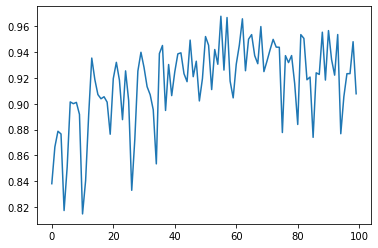

In [94]:
tas3 = train_CSBM(csbm=csbm, A_tilde=A_tilde,
           input_dim=10, hidden_dim=500, output_dim=2,
           E=10, num_epochs=100, num_train=200, batch_size=1, aggregation=mean_agg, n_k=1)

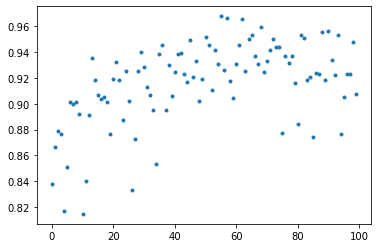

In [97]:
plt.plot(tas3, ".")

In [30]:
np.log(0.9)

-0.10536051565782628